## Code testing for PSF fitting
PSF was generated using Fiji [PSF Generator](http://bigwww.epfl.ch/algorithms/psfgenerator/) plugin.

PSF-Generator menu estimates FWHM(X,Y,Z) = 1.68, 1.68, 27.5 um (Z is too small, a plugin bug)

Fiji-fitted (manually) FWHM(X,Y,Z) = 1.73, 1.73, 37.7 um

MetroloJ plugin analysis result: FWHM(X,Y,Z) = 1.75, 1.75, 37.4 um

This code fitting results: FWHM(X,Y,Z) = 2.05, 2.05, 38.3 um

Note that PSF image should have some noise, otherwise algorithm behaves incorrectly.

In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread, find_available_plugins
import time

In [2]:
from psf import plotPSF, getCenters, getPSF

### Setup plotting

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

In [4]:
from ipywidgets import interact
from ipywidgets import IntSlider

### Define parameters

`windowUm` defines a "window" volume in microns in which only a single bead can exist (for the bead to be included in the analysis, the volume has to contain a single bright maximum).

In [5]:
# Full FOV 
MAG = 5 # Nominal magniciation of te objective
TL_f_mm = 200 # TL focal distante (200 or 180 mm)
eff_MAG = MAG * TL_f_mm/200
UmPerPxLat = 4.25/eff_MAG
pxPerUmLat = 1/UmPerPxLat
pxPerUmAx = 1.0 # between z-planes
windowUm = [90, 15, 15] # 
options = {'pxPerUmLat':pxPerUmLat, 'pxPerUmAx':pxPerUmAx, 'windowUm':windowUm}
options['thresh'] = 40000 #changed to abs, was relative: (0.05) 
options

{'pxPerUmLat': 1.1764705882352942,
 'pxPerUmAx': 1.0,
 'windowUm': [90, 15, 15],
 'thresh': 40000}

In [6]:
datafolder = "D:\\benchtopData\\PSF\\generated\\"
LENS_NAME = f"Simulation"
CAMERA = "Photometrics Iris 15"
sensor_dim_mm = (21.49, 12.61) # Iris 15
experiment_key = "simulation1noise1" 
datafiles = {
    "simulation1": datafolder + f"PSF1-fwhmXY1.68-Z27.5um.tif",
    "simulation1noise1": datafolder + f"PSF1-fwhmXY1.68-Z27.5um-noise1.tif",
}
experiment_key

'simulation1noise1'

### Load data

In [7]:
im = imread(datafiles[experiment_key], plugin='tifffile')
print(im.shape)
FOV_Y_um, FOV_X_um = im.shape[1] * UmPerPxLat, im.shape[2] * UmPerPxLat
print(FOV_Y_um, FOV_X_um)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(100, 128, 128)
108.8 108.8


### Computation

In [8]:
start_time = time.time()
beads, maxima, centers, smoothed = getCenters(im, options)
stop_time = time.time()
print('Runtime: ',stop_time-start_time, ' s')

findBeads() done: 1 found
centersM done
getCenters() done: 1 found
Runtime:  0.11984634399414062  s


In [9]:
start_time = time.time()
data = [getPSF(x, options) for x in beads]
stop_time = time.time()
print('Runtime: ',stop_time-start_time, ' s')

Runtime:  0.007001399993896484  s


In [10]:
centers = pd.DataFrame(centers, columns=['Z','Y','X'])

In [11]:
PSF = pd.concat([x[0] for x in data])
PSF['Max'] = maxima
PSF = PSF.reset_index().drop(['index'],axis=1)
latProfile = [x[1] for x in data]
axProfile = [x[2] for x in data]
PSF = PSF.join(centers)

### Inspect results

In [12]:
PSF.head()

,FWHMlat,FWHMax,Max,Z,Y,X
0,2.053923,38.322982,65518,50,63,64


In [13]:
print('# Beads: ', len(PSF))
print('\nMedian lateral FWHM (+/- std): ', round(np.median(PSF['FWHMlat']),2), ' +/- ', round(PSF['FWHMlat'].std(),2), ' μm')
print(f"MIN, MAX lateral FWHM: {round(PSF['FWHMlat'].min(),2)}, {round(PSF['FWHMlat'].max(),2)} μm")
print('\nMedian axial FWHM  (+/- std): ', round(np.nanmedian(PSF['FWHMax']),2), ' +/- ', round(PSF['FWHMax'].std(),2), ' μm')
print(f"MIN, MAX axial FWHM: {round(PSF['FWHMax'].min(),2)}, {round(PSF['FWHMax'].max(),2)}, μm")

print('\nWatch for large STD (>2 um), they indicate bad detections, e.g. multiple beads merged together.')

# Beads:  1

Median lateral FWHM (+/- std):  2.05  +/-  nan  μm
MIN, MAX lateral FWHM: 2.05, 2.05 μm

Median axial FWHM  (+/- std):  38.32  +/-  nan  μm
MIN, MAX axial FWHM: 38.32, 38.32, μm

Watch for large STD (>2 um), they indicate bad detections, e.g. multiple beads merged together.


## Sanity checks

### Plot max projection and detected beads

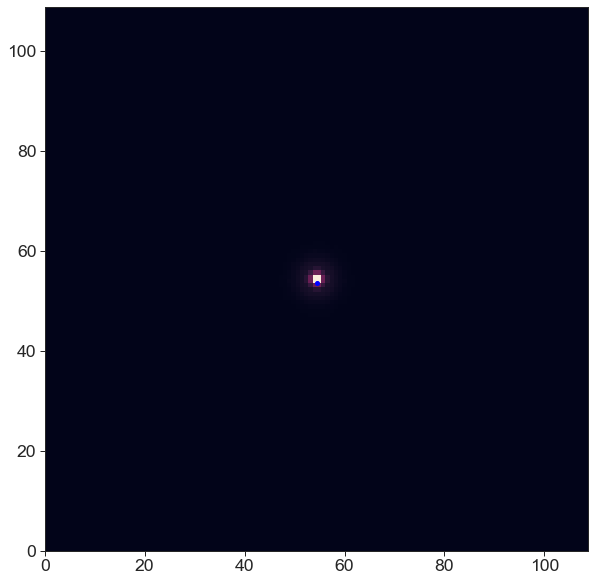

In [14]:
plt.figure(figsize=(10,10));
plt.imshow(im.max(0), extent=(0, FOV_X_um, 0, FOV_Y_um))
plt.plot((PSF['X']*UmPerPxLat).tolist(), (PSF['Y']*UmPerPxLat).tolist(), 'b.', ms=8);
#plt.axis('off'); 

## Plot XYZ projections of selected PSFs and fit

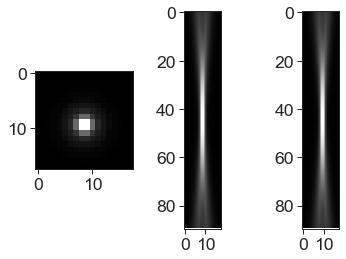

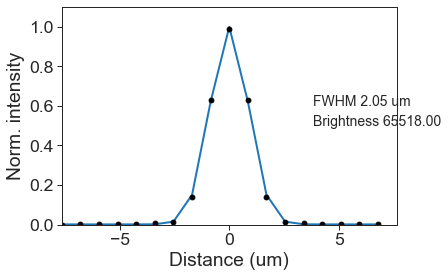

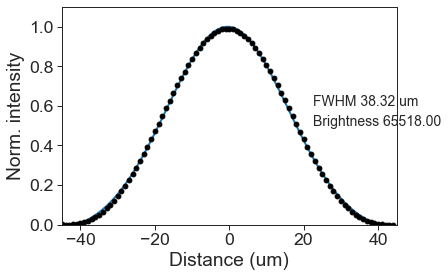

In [15]:
# Plot PSF with known ID
beadInd = 0
average = beads[beadInd]

fig, _axs = plt.subplots(nrows=1, ncols=3)
axs = _axs.flatten()

XYview = axs[0].imshow(average.mean(axis=0), cmap='gray');
XZview = axs[1].imshow(average.mean(axis=1), aspect = pxPerUmLat/pxPerUmAx, cmap='gray');
YZview = axs[2].imshow(average.mean(axis=2), aspect = pxPerUmLat/pxPerUmAx, cmap='gray');
plt.show()

plotPSF(latProfile[beadInd][0],latProfile[beadInd][1],latProfile[beadInd][2],latProfile[beadInd][3],pxPerUmLat,PSF.Max.iloc[beadInd])
plt.show()
plotPSF(axProfile[beadInd][0],axProfile[beadInd][1],axProfile[beadInd][2],axProfile[beadInd][3],pxPerUmAx,PSF.Max.iloc[beadInd])
plt.show()

In [16]:
from skimage.feature import peak_local_max
center = peak_local_max(average, min_distance=2, threshold_abs=0.99)[0]
center

array([44, 10,  8], dtype=int64)

In [17]:
average.shape

(90, 18, 18)

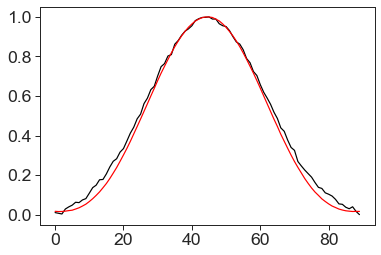

In [18]:
axProfile = (average.mean(axis=1).mean(axis=1) + average.mean(axis=2).mean(axis=1))/2
axProfile2 = average[:, center[1], center[2]]
plt.plot((axProfile-axProfile.min())/(axProfile.max() - axProfile.min()), c='k')
plt.plot(axProfile2, c= 'r')

In [19]:
latProfile1 = (average.mean(axis=0).mean(axis=1) + average.mean(axis=0).mean(axis=1))/2
latProfile2 = (average[center[0], :, center[2]] + average[center[0], center[1], :])/2

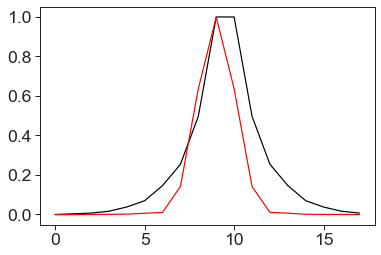

In [20]:
plt.plot((latProfile1-latProfile1.min())/(latProfile1.max() - latProfile1.min()), c='k')
plt.plot(latProfile2, c='r')

So, I found 2 bugs in definition of PSF profiles, and they make a big difference in PSF estimation. The `psf` code is now corrected.